This is the cumulative project file including Data Preprocessing, Normalization, Visualization, Model Selection and Implementation. 

We start off with packages and imports required to run our code:

In [31]:
# baseline cnn model for fashion mnist
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

<h1>1.Data Preparation</h1> 

<b>Data Description:</b> The dataset we are using is the Fashion MNIST Dataset. It contains 60000 training images and 10000 test images. The images are of size 28*28 and consist of 1 channel (Grayscale).

<b>Data Cleaning:</b> As the dataset contained no missing values and was also balanced when we obtained the dataset, we did not proceed with any cleaning step and used the precleaned dataset.

The code below shows the spread of data. As it is uniformly spread across all classes, no balancing was required.

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
labels = ['T-shirt/top','Trouser','Pullover','Dress', 'Coat', 'Sandal', 'Shirt', 'Sneakers', 'Bag', 'Ankle boot']
len(labels)

10

In [5]:
np.unique(train_labels, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

<b>Data Splitting:</b> We'll now split the data into training, validation and testing dataset. Fashion MNIST by default has train and test splits. We'll also add a validation split that will split the training data into training and validation data:

In [6]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Testing data shape: {test_images.shape}")
print(f"Testing labels shape: {test_labels.shape}")

Training data shape: (48000, 28, 28)
Training labels shape: (48000,)
Validation data shape: (12000, 28, 28)
Validation labels shape: (12000,)
Testing data shape: (10000, 28, 28)
Testing labels shape: (10000,)


The check for null values is as shown below:

In [7]:
train_data = pd.DataFrame({'Image': [img.flatten() for img in X_train], 'Label': y_train})
val_data = pd.DataFrame({'Image': [img.flatten() for img in X_val], 'Label': y_val})
test_data = pd.DataFrame({'Image': [img.flatten() for img in test_images], 'Label': test_labels})
train_data['Label'] = train_data['Label'].map(lambda x: labels[x])
test_data['Label'] = test_data['Label'].map(lambda x: labels[x])
print("Null values in train data:", train_data.isnull().sum())
print("Null values in validation data:", val_data.isnull().sum())
print("Null values in test data:", test_data.isnull().sum())


Null values in train data: Image    0
Label    0
dtype: int64
Null values in validation data: Image    0
Label    0
dtype: int64
Null values in test data: Image    0
Label    0
dtype: int64


<b>Data Transformation:</b> As every pixel contains a decimal number in the range 0-255, we will need to normalize the data to the range (0,1):

In [8]:
train_images = X_train / 255.0
val_images = X_val / 255.0
test_images = test_images / 255.0

We'll also do PCA later so we need the original dimensions before reshaping:

In [9]:
train_images_pca = train_images
val_images_pca =  val_images
test_images_pca = test_images
print(train_images.shape)
print(test_images.shape)
print(test_images.shape)

(48000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


We'll also need to shape the data as per the required dimensions of classifiers:

In [10]:
train_images = train_images.reshape(X_train.shape[0], -1)
val_images =  val_images.reshape(X_val.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)
print(train_images.shape)
print(test_images.shape)
print(test_images.shape)

(48000, 784)
(10000, 784)
(10000, 784)


In [11]:
train_labels = y_train
val_labels = y_val

<h1>2.Exploratory Data Analysis</h1>

Descriptive Statistics: Below is the code and the graphs to plot the class distributions of the dataset:

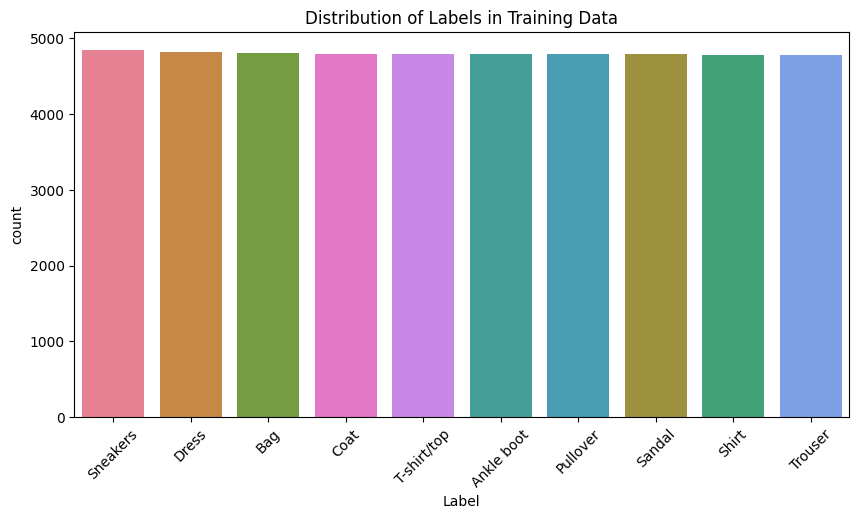

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
palette = sns.color_palette("husl", len(train_data['Label'].unique()))

sns.countplot(data=train_data, x='Label', order=train_data['Label'].value_counts().index, hue='Label', palette=palette, dodge=False, legend=False)
plt.title('Distribution of Labels in Training Data')
plt.xticks(rotation=45)
plt.show()


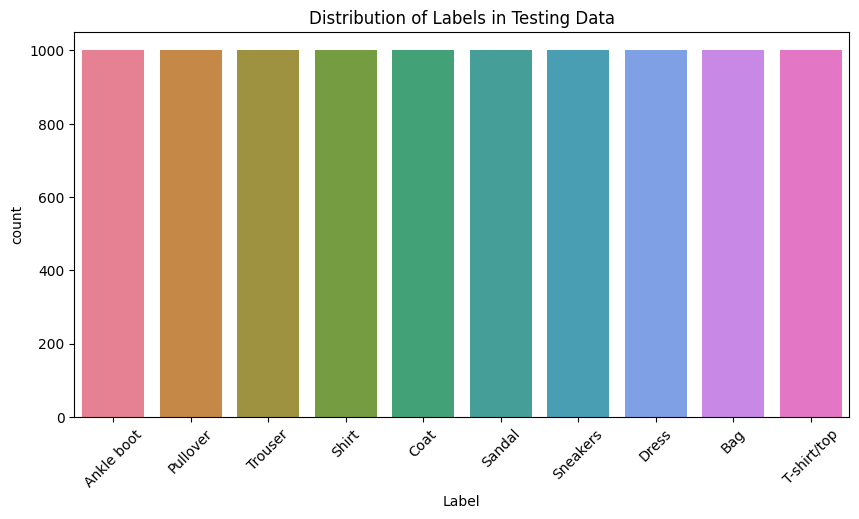

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
palette = sns.color_palette("husl", len(test_data['Label'].unique()))

sns.countplot(data=test_data, x='Label', order=test_data['Label'].value_counts().index, hue='Label', palette=palette, dodge=False, legend=False)
plt.title('Distribution of Labels in Testing Data')
plt.xticks(rotation=45)
plt.show()


<h1>3.Model Selection</h1>

<b>We have used a baseline CNN model to classify the Fasion MNIST Dataset with a test set accuracy of 90.87%</b>

<b>Justification: We'll now use FMNIST and check metrics of Classical ML Models on FMNIST</b>

We'll start with KNeighborsClassifier:

In [14]:
# Initialize the KNN model with optimal n_neighbors based on the training set size
knn = KNeighborsClassifier(n_neighbors=int(np.sqrt(train_images.shape[0]) / 2))

# Fit the model on the training data
knn.fit(train_images, train_labels)

# Predictions for the test set
test_predictions = knn.predict(test_images)

# Accuracy on the test set
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Set Accuracy (in %):", test_accuracy * 100)

# Accuracy on the training set
train_predictions = knn.predict(train_images)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Set Accuracy (in %):", train_accuracy * 100)

# Accuracy on the validation set
val_predictions = knn.predict(val_images)
val_accuracy = accuracy_score(val_labels, val_predictions)
print("Validation Set Accuracy (in %):", val_accuracy * 100)

# Precision, recall, and F1 score for the test set
test_precision = precision_score(test_labels, test_predictions, average='weighted')
test_recall = recall_score(test_labels, test_predictions, average='weighted')
test_f1 = f1_score(test_labels, test_predictions, average='weighted')
print("Test Set Precision (in %):", test_precision * 100)
print("Test Set Recall (in %):", test_recall * 100)
print("Test Set F1 Score (in %):", test_f1 * 100)

# Precision, recall, and F1 score for the validation set
val_precision = precision_score(val_labels, val_predictions, average='weighted')
val_recall = recall_score(val_labels, val_predictions, average='weighted')
val_f1 = f1_score(val_labels, val_predictions, average='weighted')
print("Validation Set Precision (in %):", val_precision * 100)
print("Validation Set Recall (in %):", val_recall * 100)
print("Validation Set F1 Score (in %):", val_f1 * 100)


Test Set Accuracy (in %): 80.91000000000001
Training Set Accuracy (in %): 81.9625
Validation Set Accuracy (in %): 80.79166666666666
Test Set Precision (in %): 81.6518593626045
Test Set Recall (in %): 80.91000000000001
Test Set F1 Score (in %): 80.92299644582538
Validation Set Precision (in %): 81.40439262779446
Validation Set Recall (in %): 80.79166666666666
Validation Set F1 Score (in %): 80.69051086056606


We see a test accuracy of 80.91 with precision of 81.65, recall of 80.90 and F1 score of 80.92

Let's employ Random Forest Classifier now:

In [15]:
# Initialize the Random Forest model
rf = RandomForestClassifier(max_depth=20)  # You can adjust n_estimators as needed

# Fit the model on the training data
rf.fit(train_images, train_labels)

# Predictions for the test set
test_predictions = rf.predict(test_images)

# Accuracy on the test set
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Set Accuracy (in %):", test_accuracy * 100)

# Accuracy on the training set
train_predictions = rf.predict(train_images)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Set Accuracy (in %):", train_accuracy * 100)

# Accuracy on the validation set
val_predictions = rf.predict(val_images)
val_accuracy = accuracy_score(val_labels, val_predictions)
print("Validation Set Accuracy (in %):", val_accuracy * 100)

# Precision, recall, and F1 score for the test set
test_precision = precision_score(test_labels, test_predictions, average='weighted')
test_recall = recall_score(test_labels, test_predictions, average='weighted')
test_f1 = f1_score(test_labels, test_predictions, average='weighted')
print("Test Set Precision (in %):", test_precision * 100)
print("Test Set Recall (in %):", test_recall * 100)
print("Test Set F1 Score (in %):", test_f1 * 100)

# Precision, recall, and F1 score for the validation set
val_precision = precision_score(val_labels, val_predictions, average='weighted')
val_recall = recall_score(val_labels, val_predictions, average='weighted')
val_f1 = f1_score(val_labels, val_predictions, average='weighted')
print("Validation Set Precision (in %):", val_precision * 100)
print("Validation Set Recall (in %):", val_recall * 100)
print("Validation Set F1 Score (in %):", val_f1 * 100)


Test Set Accuracy (in %): 87.42
Training Set Accuracy (in %): 99.38333333333334
Validation Set Accuracy (in %): 87.80833333333334
Test Set Precision (in %): 87.33103054469335
Test Set Recall (in %): 87.42
Test Set F1 Score (in %): 87.28035950469682
Validation Set Precision (in %): 87.71762375181763
Validation Set Recall (in %): 87.80833333333334
Validation Set F1 Score (in %): 87.63161858495904


Random Forest Classifier does better than KNeighbors by providing an accuracy of 87.2, precision of 87.10, recall of 87.2 and F1 score of 87.06 on the test set.

We'll now use SVM for the Classification:

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize the SVM model
svm = SVC(kernel='poly')

# Fit the model on the training data
svm.fit(train_images, train_labels)

# Predictions for the test set
test_predictions = svm.predict(test_images)

# Accuracy on the test set
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Set Accuracy (in %):", test_accuracy * 100)

# Accuracy on the training set
train_predictions = svm.predict(train_images)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Set Accuracy (in %):", train_accuracy * 100)

# Accuracy on the validation set
val_predictions = svm.predict(val_images)
val_accuracy = accuracy_score(val_labels, val_predictions)
print("Validation Set Accuracy (in %):", val_accuracy * 100)

# Precision, recall, and F1 score for the test set
test_precision = precision_score(test_labels, test_predictions, average='weighted')
test_recall = recall_score(test_labels, test_predictions, average='weighted')
test_f1 = f1_score(test_labels, test_predictions, average='weighted')
print("Test Set Precision (in %):", test_precision * 100)
print("Test Set Recall (in %):", test_recall * 100)
print("Test Set F1 Score (in %):", test_f1 * 100)

# Precision, recall, and F1 score for the validation set
val_precision = precision_score(val_labels, val_predictions, average='weighted')
val_recall = recall_score(val_labels, val_predictions, average='weighted')
val_f1 = f1_score(val_labels, val_predictions, average='weighted')
print("Validation Set Precision (in %):", val_precision * 100)
print("Validation Set Recall (in %):", val_recall * 100)
print("Validation Set F1 Score (in %):", val_f1 * 100)


Test Set Accuracy (in %): 85.77
Training Set Accuracy (in %): 90.68125
Validation Set Accuracy (in %): 86.84166666666667
Test Set Precision (in %): 86.02256996463515
Test Set Recall (in %): 85.77
Test Set F1 Score (in %): 85.80895081608605
Validation Set Precision (in %): 87.11326912620272
Validation Set Recall (in %): 86.84166666666667
Validation Set F1 Score (in %): 86.86778727444073


The SVM provided a test accuracy of 85.77, precision score of 86.02, recall of 85.77, and F1 score of 85.80.

Gaussian Naive Bayes is also used on FMNIST to check its efficacy:

In [17]:
# Initialize the Gaussian Naive Bayes model
gnb = GaussianNB()

# Fit the model on the training data
gnb.fit(train_images, train_labels)

# Predictions for the test set
test_predictions = gnb.predict(test_images)

# Accuracy on the test set
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Set Accuracy (in %):", test_accuracy * 100)

# Accuracy on the training set
train_predictions = gnb.predict(train_images)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Set Accuracy (in %):", train_accuracy * 100)

# Accuracy on the validation set
val_predictions = gnb.predict(val_images)
val_accuracy = accuracy_score(val_labels, val_predictions)
print("Validation Set Accuracy (in %):", val_accuracy * 100)

# Precision, recall, and F1 score for the test set
test_precision = precision_score(test_labels, test_predictions, average='weighted')
test_recall = recall_score(test_labels, test_predictions, average='weighted')
test_f1 = f1_score(test_labels, test_predictions, average='weighted')
print("Test Set Precision (in %):", test_precision * 100)
print("Test Set Recall (in %):", test_recall * 100)
print("Test Set F1 Score (in %):", test_f1 * 100)

# Precision, recall, and F1 score for the validation set
val_precision = precision_score(val_labels, val_predictions, average='weighted')
val_recall = recall_score(val_labels, val_predictions, average='weighted')
val_f1 = f1_score(val_labels, val_predictions, average='weighted')
print("Validation Set Precision (in %):", val_precision * 100)
print("Validation Set Recall (in %):", val_recall * 100)
print("Validation Set F1 Score (in %):", val_f1 * 100)


Test Set Accuracy (in %): 58.25
Training Set Accuracy (in %): 58.46041666666667
Validation Set Accuracy (in %): 58.199999999999996
Test Set Precision (in %): 63.47596326132739
Test Set Recall (in %): 58.25
Test Set F1 Score (in %): 55.26257806947444
Validation Set Precision (in %): 64.12810860580657
Validation Set Recall (in %): 58.199999999999996
Validation Set F1 Score (in %): 55.27293415559146


We can see that Naive Bayes (Gaussian) doesn't fit the data well as it shows a low test accuracy of 58.25 and training accuracy of 58.46.

Multinomial Naive Bayes comes up next:

In [18]:
# Initialize the Multinomial Naive Bayes model
nb = MultinomialNB()

# Fit the model on the training data
nb.fit(train_images, train_labels)

# Predictions for the test set
test_predictions = nb.predict(test_images)

# Accuracy on the test set
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Set Accuracy (in %):", test_accuracy * 100)

# Accuracy on the training set
train_predictions = nb.predict(train_images)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Set Accuracy (in %):", train_accuracy * 100)

# Accuracy on the validation set
val_predictions = nb.predict(val_images)
val_accuracy = accuracy_score(val_labels, val_predictions)
print("Validation Set Accuracy (in %):", val_accuracy * 100)

# Precision, recall, and F1 score for the test set
test_precision = precision_score(test_labels, test_predictions, average='weighted')
test_recall = recall_score(test_labels, test_predictions, average='weighted')
test_f1 = f1_score(test_labels, test_predictions, average='weighted')
print("Test Set Precision (in %):", test_precision * 100)
print("Test Set Recall (in %):", test_recall * 100)
print("Test Set F1 Score (in %):", test_f1 * 100)

# Precision, recall, and F1 score for the validation set
val_precision = precision_score(val_labels, val_predictions, average='weighted')
val_recall = recall_score(val_labels, val_predictions, average='weighted')
val_f1 = f1_score(val_labels, val_predictions, average='weighted')
print("Validation Set Precision (in %):", val_precision * 100)
print("Validation Set Recall (in %):", val_recall * 100)
print("Validation Set F1 Score (in %):", val_f1 * 100)


Test Set Accuracy (in %): 65.61
Training Set Accuracy (in %): 66.82083333333333
Validation Set Accuracy (in %): 66.44166666666666
Test Set Precision (in %): 65.47085778846046
Test Set Recall (in %): 65.61
Test Set F1 Score (in %): 62.82674352655485
Validation Set Precision (in %): 66.70992166934685
Validation Set Recall (in %): 66.44166666666666
Validation Set F1 Score (in %): 63.6104654994915


We now provide a table of the metrics obtained uptil now:

In [19]:
import pandas as pd
from tabulate import tabulate

# Combined data for all cases
data = {
    'Model': ['KNeighbors', 'Random Forest', 'SVM','GaussianNB','MultinomialNB'],
    'Test Accuracy (%)': [80.91,87.2,85.77,58.25,65.61],
    'Training Accuracy (%)': [81.96,99.41,90.68,58.46,66.82],
    'Validation Accuracy (%)': [80.79,87.8,86.84,58.19,66.44],
    'Test Precision (%)': [81.65,87.10,86.02,63.47,65.47],
    'Test Recall (%)': [80.91,87.2,85.77,58.25,65.61],
    'Test F1 Score': [80.92,87.06,85.80,55.26,62.82]
}

# Dictionary to a Pandas Dataframe will form the Table
df = pd.DataFrame(data)
df.set_index('Model', inplace=True)
print(tabulate(df, headers='keys', tablefmt='grid'))


+---------------+---------------------+-------------------------+---------------------------+----------------------+-------------------+-----------------+
| Model         |   Test Accuracy (%) |   Training Accuracy (%) |   Validation Accuracy (%) |   Test Precision (%) |   Test Recall (%) |   Test F1 Score |
+===============+=====================+=========================+===========================+======================+===================+=================+
| KNeighbors    |               80.91 |                   81.96 |                     80.79 |                81.65 |             80.91 |           80.92 |
+---------------+---------------------+-------------------------+---------------------------+----------------------+-------------------+-----------------+
| Random Forest |               87.2  |                   99.41 |                     87.8  |                87.1  |             87.2  |           87.06 |
+---------------+---------------------+-------------------------+-----

We will now use PCA to see if we can better our metrics beyond the above observed metrics:

In [20]:
# Flatten the images and create a DataFrame
n_samples, width, height = train_images_pca.shape
n_samples_val, width_val, height_val = val_images_pca.shape
n_sample_test, width_test, height_test = test_images_pca.shape

flat_images = train_images_pca.reshape(n_samples, width * height)  # Flatten each image to 1D array
flat_images_val = val_images_pca.reshape(n_samples_val, width_val * height_val)  # Flatten each image to 1D array
flat_images_test = test_images_pca.reshape(n_sample_test, width_test * height_test)

# Standardize the data before PCA
scaler = StandardScaler()
flat_images_scaled = scaler.fit_transform(flat_images)
flat_images_scaled_val = scaler.fit_transform(flat_images_val)
flat_images_scaled_test = scaler.fit_transform(flat_images_test)

# Apply PCA to reduce to 100 components
pca = PCA(n_components=100)
train_images_pca = pca.fit_transform(flat_images_scaled)
val_images_pca = pca.fit_transform(flat_images_scaled_val)
test_images_pca = pca.transform(flat_images_scaled_test)


We'll apply the new data to the models now.

Lets try the KNeighbors with PCA model:

In [21]:
# Initialize the KNN model with optimal n_neighbors based on the training set size
knn = KNeighborsClassifier(n_neighbors=int(np.sqrt(train_images_pca.shape[0]) / 2))

# Fit the model on the training data
knn.fit(train_images_pca, train_labels)

# Predictions for the test set
test_predictions = knn.predict(test_images_pca)

# Accuracy on the test set
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Set Accuracy (in %):", test_accuracy * 100)

# Accuracy on the training set
train_predictions = knn.predict(train_images_pca)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Set Accuracy (in %):", train_accuracy * 100)

# Accuracy on the validation set
val_predictions = knn.predict(val_images_pca)
val_accuracy = accuracy_score(val_labels, val_predictions)
print("Validation Set Accuracy (in %):", val_accuracy * 100)

# Precision, recall, and F1 score for the test set
test_precision = precision_score(test_labels, test_predictions, average='weighted')
test_recall = recall_score(test_labels, test_predictions, average='weighted')
test_f1 = f1_score(test_labels, test_predictions, average='weighted')
print("Test Set Precision (in %):", test_precision * 100)
print("Test Set Recall (in %):", test_recall * 100)
print("Test Set F1 Score (in %):", test_f1 * 100)

# Precision, recall, and F1 score for the validation set
val_precision = precision_score(val_labels, val_predictions, average='weighted')
val_recall = recall_score(val_labels, val_predictions, average='weighted')
val_f1 = f1_score(val_labels, val_predictions, average='weighted')
print("Validation Set Precision (in %):", val_precision * 100)
print("Validation Set Recall (in %):", val_recall * 100)
print("Validation Set F1 Score (in %):", val_f1 * 100)

Test Set Accuracy (in %): 55.669999999999995
Training Set Accuracy (in %): 83.6625
Validation Set Accuracy (in %): 55.300000000000004
Test Set Precision (in %): 58.01063126432163
Test Set Recall (in %): 55.669999999999995
Test Set F1 Score (in %): 54.08114091340577
Validation Set Precision (in %): 57.89550998761751
Validation Set Recall (in %): 55.300000000000004
Validation Set F1 Score (in %): 53.528479650359


The accuracy Drastically went down.

We'll do one more check for Random Forest Classifier with PCA:

In [22]:
# Initialize the Random Forest model
rf = RandomForestClassifier(max_depth=20)  # You can adjust n_estimators as needed

# Fit the model on the training data
rf.fit(train_images_pca, train_labels)

# Predictions for the test set
test_predictions = rf.predict(test_images_pca)

# Accuracy on the test set
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Set Accuracy (in %):", test_accuracy * 100)

# Accuracy on the training set
train_predictions = rf.predict(train_images_pca)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Set Accuracy (in %):", train_accuracy * 100)

# Accuracy on the validation set
val_predictions = rf.predict(val_images_pca)
val_accuracy = accuracy_score(val_labels, val_predictions)
print("Validation Set Accuracy (in %):", val_accuracy * 100)

# Precision, recall, and F1 score for the test set
test_precision = precision_score(test_labels, test_predictions, average='weighted')
test_recall = recall_score(test_labels, test_predictions, average='weighted')
test_f1 = f1_score(test_labels, test_predictions, average='weighted')
print("Test Set Precision (in %):", test_precision * 100)
print("Test Set Recall (in %):", test_recall * 100)
print("Test Set F1 Score (in %):", test_f1 * 100)

# Precision, recall, and F1 score for the validation set
val_precision = precision_score(val_labels, val_predictions, average='weighted')
val_recall = recall_score(val_labels, val_predictions, average='weighted')
val_f1 = f1_score(val_labels, val_predictions, average='weighted')
print("Validation Set Precision (in %):", val_precision * 100)
print("Validation Set Recall (in %):", val_recall * 100)
print("Validation Set F1 Score (in %):", val_f1 * 100)


Test Set Accuracy (in %): 57.57
Training Set Accuracy (in %): 99.65416666666667
Validation Set Accuracy (in %): 57.891666666666666
Test Set Precision (in %): 56.1558316721196
Test Set Recall (in %): 57.57
Test Set F1 Score (in %): 55.985049515158245
Validation Set Precision (in %): 56.22911053259967
Validation Set Recall (in %): 57.891666666666666
Validation Set F1 Score (in %): 56.17543430964146


<b>The PCA Strategy Doesn't work in this case as well because the test accuracy is again lowered. Thus,we conclude from these results that PCA seems to be inefficient with respect to our models.</b>

<b>We can see that the accuracy without PCA reaches a maximum of 87.2 in the case of Random Forest Classifier. We wanted to increase the accuracy beyond this point so we use a Convolutional Neural Network to achieve this.<b>

We initially started with a CNN having an accuracy of 86.730 on the test set and used hyperparameter tuning to increase our accuracy to 90.470.

Common steps employed before using the model are coded below:

In [23]:
# baseline cnn model for fashion mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

In [24]:
# load dataset
# load train and test dataset
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
  valX = trainX[50000:]
  valY = trainY[50000:]
  trainX = trainX[:50000]
  trainY = trainY[:50000]
  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  valX = valX.reshape((valX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))
  # one hot encode target values
  trainY = to_categorical(trainY)
  valY = to_categorical(valY)
  testY = to_categorical(testY)
  return trainX, trainY, valX, valY, testX, testY

In [ ]:
# scale pixels
def prep_pixels(train, val, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	val_norm = val.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	val_norm = val_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, val_norm, test_norm

Initial model is shown below:

In [35]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model


Epoch 1/10


d:\TAMU\SemesterStudies\Sem1\ECEN758-Mr.Joshua_Peeples_DS_Data_Mining_and_Analysis\Project\Ecen758-Project\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7056 - loss: 0.8211 - val_accuracy: 0.8061 - val_loss: 0.5347
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8362 - loss: 0.4545 - val_accuracy: 0.8477 - val_loss: 0.4251
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8574 - loss: 0.3988 - val_accuracy: 0.8480 - val_loss: 0.4212
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8709 - loss: 0.3571 - val_accuracy: 0.8543 - val_loss: 0.4057
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8782 - loss: 0.3366 - val_accuracy: 0.8784 - val_loss: 0.3427
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8869 - loss: 0.3145 - val_accuracy: 0.8747 - val_loss: 0.3445
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8900 - loss: 0.3097 - val_accuracy: 0.8827 - val_loss: 0.3283
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8931 - loss: 0.2897 - val

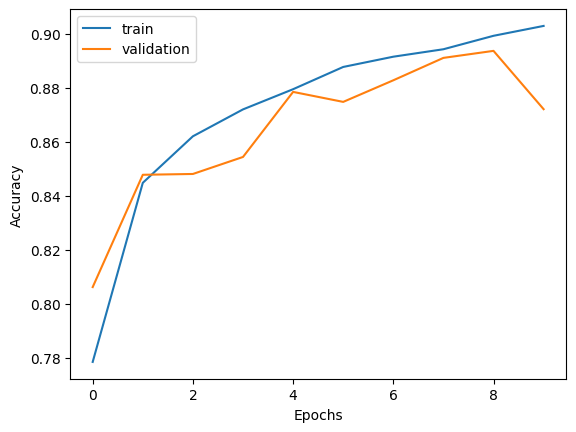

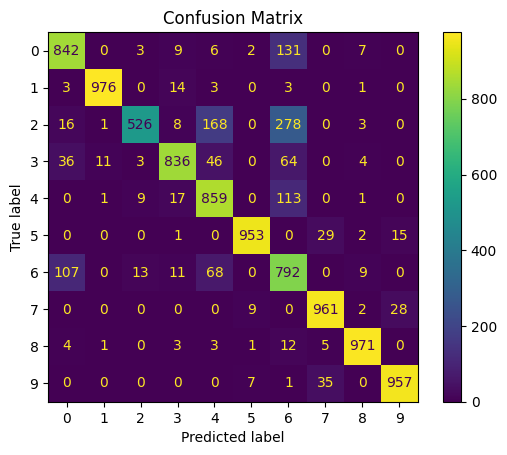

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.84      0.84      1000
     Class 1       0.99      0.98      0.98      1000
     Class 2       0.95      0.53      0.68      1000
     Class 3       0.93      0.84      0.88      1000
     Class 4       0.75      0.86      0.80      1000
     Class 5       0.98      0.95      0.97      1000
     Class 6       0.57      0.79      0.66      1000
     Class 7       0.93      0.96      0.95      1000
     Class 8       0.97      0.97      0.97      1000
     Class 9       0.96      0.96      0.96      1000

    accuracy                           0.87     10000
   macro avg       0.89      0.87      0.87     10000
weighted avg       0.89      0.87      0.87     10000



In [38]:
def train_and_evaluate(filename):
    # load dataset
    trainX, trainY, valX, valY, testX, testY = load_dataset()
    # preprocess pixel values
    trainX, valX, testX = prep_pixels(trainX, valX, testX)
    # define model
    model = define_model()
    # fit model on the training dataset
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(valX, valY), verbose=1)
    #save the model 
    if filename == "":
        print("Model Not saved")
    else:
        model.save_weights(filename)
        print("Model weights saved to ",str(filename))
    # evaluate the model on the test dataset
    _, accuracy = model.evaluate(testX, testY, verbose=0)
    print(f'Test Accuracy: {accuracy * 100.0:.3f}%')

    # Plot learning curves
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='validation')
    pyplot.xlabel('Epochs')
    pyplot.ylabel('Accuracy')
    pyplot.legend()
    pyplot.show()

    # Predict the test set and calculate the confusion matrix
    predictions = np.argmax(model.predict(testX, verbose=0), axis=1)
    true_labels = np.argmax(testY, axis=1)
    
    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis')
    pyplot.title("Confusion Matrix")
    pyplot.show()

    # Compute precision, recall, and F1-score
    report = classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(len(cm))])
    print("Classification Report:")
    print(report)

# Run the training and evaluation process
train_and_evaluate("")

We can see that there are some misclassifications but the CNN model does better compared to classical ML techniques. A key observation that can be made is the category 6 is misclassified the most. Around 50% of the classifications are incorrect so we have a scope of improvement there.

We then used a learning rate along with a momentum of 0.9, reduced the filter to size 32 and increased the dense layer neurons to 100. This increased our accuracy to 90.470.

In [41]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model


Epoch 1/10


d:\TAMU\SemesterStudies\Sem1\ECEN758-Mr.Joshua_Peeples_DS_Data_Mining_and_Analysis\Project\Ecen758-Project\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7943 - loss: 0.5751 - val_accuracy: 0.8861 - val_loss: 0.3180
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8932 - loss: 0.2932 - val_accuracy: 0.8982 - val_loss: 0.2795
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9099 - loss: 0.2438 - val_accuracy: 0.9047 - val_loss: 0.2666
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9223 - loss: 0.2144 - val_accuracy: 0.9059 - val_loss: 0.2586
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9316 - loss: 0.1873 - val_accuracy: 0.9061 - val_loss: 0.2680
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9391 - loss: 0.1683 - val_accuracy: 0.9021 - val_loss: 0.2784
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9460 - loss: 0.1470 - val_accuracy: 0.9087 - val_loss: 0.2694
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9513 - loss: 0.1323 - val_accurac

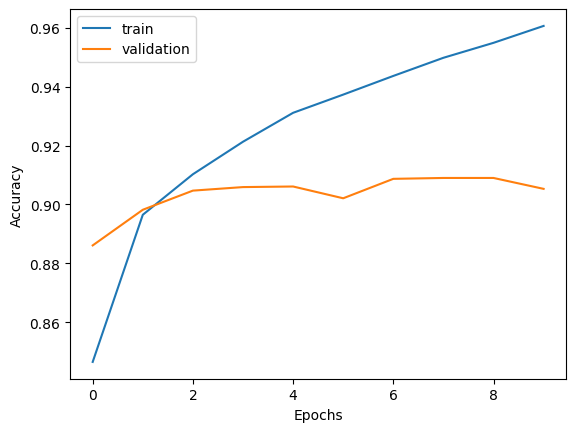

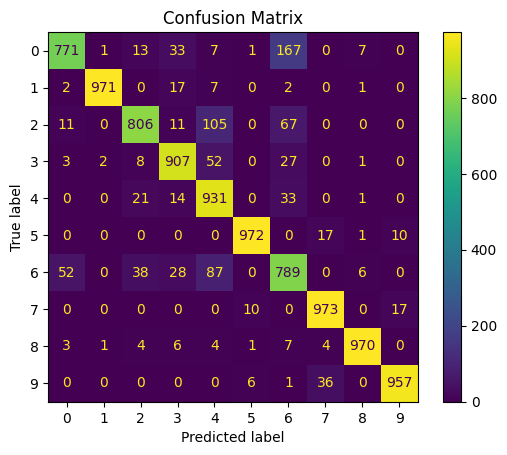

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      0.77      0.84      1000
     Class 1       1.00      0.97      0.98      1000
     Class 2       0.91      0.81      0.85      1000
     Class 3       0.89      0.91      0.90      1000
     Class 4       0.78      0.93      0.85      1000
     Class 5       0.98      0.97      0.98      1000
     Class 6       0.72      0.79      0.75      1000
     Class 7       0.94      0.97      0.96      1000
     Class 8       0.98      0.97      0.98      1000
     Class 9       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.91     10000
weighted avg       0.91      0.90      0.91     10000



In [42]:
train_and_evaluate('model_weights.weights.h5')

We can see that the numbers have gone up in this confusion matrix and the test accuracy has also reached beyond the 90 mark. A key distinction between the two CNN models is the category 6 classifications have improved by a lot. This is the reason for the spike in the accuracy.

The macro average and weighted average is the same because we do not have a class imbalance in this case.